In [1]:
# 데이터 조작 라이브러리
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# pip install tensorflow==2.11.0

In [3]:
from tensorflow.python.client import device_lib
# 장치 목록 확인
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6284846777625150441
xla_global_id: -1
]


In [4]:
featruesData = pd.read_csv("../../dataset/feature_regression_example.csv")
featruesData

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155
...,...,...,...,...,...,...,...,...,...,...,...,...
100,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201648,2016,48,2412,Y,0,Y,0.421888
101,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201649,2016,49,1955,N,4,Y,0.421888
102,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201650,2016,50,1800,N,4,Y,0.352361
103,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201651,2016,51,1173,N,4,Y,0.352361


# A. 데이터 전처리

### A-1. 타입통합 / 특성 숫자컬럼 추가

In [5]:
ynDict = {"Y":1,"N":0}

In [6]:
featruesData["PROMOTION_YN"] = featruesData.PROMOTION.map(ynDict)
featruesData["HOLIDAY_YN"] = featruesData.HOLIDAY.map(ynDict)

### A-2. 특성선정 및 데이터 분리shape

In [7]:
label = ["QTY"]

In [8]:
# 숫자형 컬럼만 선택
# np.number 숫자이외엔 버린다
features = list(featruesData.select_dtypes(np.number).columns)

# 정답지 분리
# set은 기존에 있는 거에서 뺄 수 있다.
features = list(set(features) - set(label))
print("label: {}".format(label))
features = ['HOLIDAY_YN', 'HCLUS', 'PROMOTION_YN', 'PRO_PERCENT']
print("features: {}".format(features))

label: ['QTY']
features: ['HOLIDAY_YN', 'HCLUS', 'PROMOTION_YN', 'PRO_PERCENT']


In [9]:
stdRatio = 0.8

In [10]:
stdIndex = int(featruesData.shape[0] * stdRatio)
stdIndex

84

In [11]:
stdYearWeek = featruesData.loc[stdIndex].YEARWEEK
stdYearWeek

201632

In [12]:
trainData = featruesData.loc[featruesData.YEARWEEK < stdYearWeek]

In [13]:
trainfeat = featruesData.loc[featruesData.YEARWEEK < stdYearWeek, features]
trainlabel = featruesData.loc[featruesData.YEARWEEK < stdYearWeek, label]
testfeat = featruesData.loc[featruesData.YEARWEEK >= stdYearWeek, features]
testlabel = featruesData.loc[featruesData.YEARWEEK >= stdYearWeek, label]

In [14]:
print(trainfeat.shape)
print(trainlabel.shape)
print(testfeat.shape)
print(testlabel.shape)

(84, 4)
(84, 1)
(21, 4)
(21, 1)


# B 모델 생성 / 훈련

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [16]:
inputShape = trainfeat.loc[0,:].shape
inputShape

(4,)

In [17]:
model = Sequential()

# 동그라미 갯수 = units, 동그라미 갯수만큼 bias가 생긴다.
# units는 4의 배수가 좋다.
# y = wx + b, w:weight, b:bias
model.add(Dense(units=32, activation="relu", input_shape = inputShape))#, name="sss") ) # 시작
model.add(Dense(units=256, activation="relu")) # 히든 레이어
model.add(Dense(units=1, activation="relu")) # 끝

In [18]:
# 모델에 대한 
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 256)               8448      
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8,865
Trainable params: 8,865
Non-trainable params: 0
_________________________________________________________________


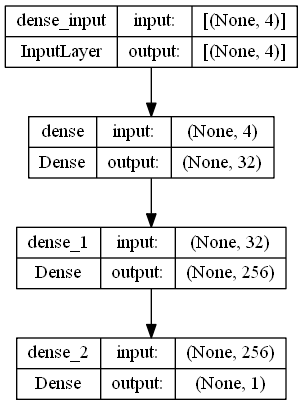

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True) 

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

### B-4. 컴파일

In [21]:
model.compile( loss="mean_squared_error",
              optimizer = "adam",
               metrics = ["mean_squared_error","mean_absolute_error"])

### B-5. 훈련

In [22]:
history = model.fit( x=trainfeat, 
            y=trainlabel,
            batch_size=32, # 문제지를 32개씩 끊어본다. 1epoch에 weight+bias가 3번 업데이트 된다.
            epochs=500, # 전체문항을 다 봤을때 1epoch / 500epoch하면, batch_size까지 고려하면 1500이 된다.
            validation_split=0.2, #없으면 애는 무조건 1000,10000 정확도가 100%가 될 수 밖에 없다.
                                  # overfitting된다. 정확도는 100%지만, 쓸 수 없는 모델이다.
                                  # epoch가 한번 넘어갈 때마다 해당 비율로 따로 빼서 푼다.
                                  # val_MSE가 줄다가 어느 순간 올라간다.
         )
# 훈련을 돌릴때마다 마지막 weight부터 시작한다.

Epoch 1/500
3/3 [==============================] - 1s 91ms/step - loss: 1948305.6250 - mean_squared_error: 1948305.6250 - mean_absolute_error: 1114.3157 - val_loss: 1831167.8750 - val_mean_squared_error: 1831167.8750 - val_mean_absolute_error: 1143.1328
Epoch 2/500
3/3 [==============================] - 0s 22ms/step - loss: 1947931.8750 - mean_squared_error: 1947931.8750 - mean_absolute_error: 1114.1361 - val_loss: 1830706.7500 - val_mean_squared_error: 1830706.7500 - val_mean_absolute_error: 1142.8888
Epoch 3/500
3/3 [==============================] - 0s 16ms/step - loss: 1947420.0000 - mean_squared_error: 1947420.0000 - mean_absolute_error: 1113.8710 - val_loss: 1830235.0000 - val_mean_squared_error: 1830235.0000 - val_mean_absolute_error: 1142.6379
Epoch 4/500
3/3 [==============================] - 0s 14ms/step - loss: 1946912.5000 - mean_squared_error: 1946912.5000 - mean_absolute_error: 1113.5913 - val_loss: 1829740.1250 - val_mean_squared_error: 1829740.1250 - val_mean_absolute_e

### 예측

In [23]:
features

['HOLIDAY_YN', 'HCLUS', 'PROMOTION_YN', 'PRO_PERCENT']

In [24]:
featruesData.PRO_PERCENT.drop_duplicates()

0      0.209442
2      0.208155
9      0.000000
25     0.280258
34     0.237768
44     0.357511
77     0.308584
96     0.421888
102    0.352361
Name: PRO_PERCENT, dtype: float64

In [25]:
inHoli = 1
inHclus = 4
inPROMO = 1
inProper = 0.3

In [26]:
from sklearn import neural_network

In [27]:
neural_network.MLPRegressor()

MLPRegressor()

In [28]:
testDf = pd.DataFrame([[inHoli,inHclus,inPROMO,inProper]])
testDf

,0,1,2,3
0,1,4,1,0.3


In [29]:
model.predict(testDf)

1/1 [==============================] - 0s 75ms/step


array([[1657.7374]], dtype=float32)

# 모델저장

In [30]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("linear_keras_sellout.h5")